arm64


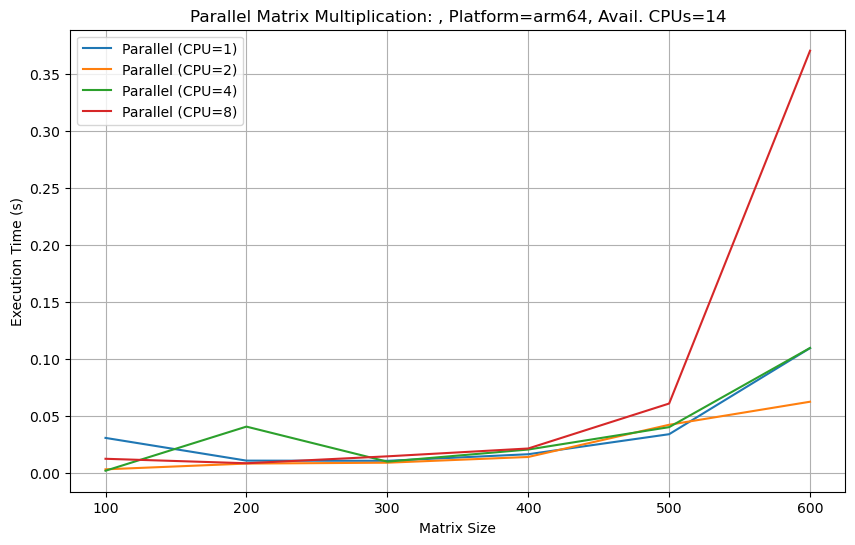

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import time
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures
import logging as log
import platform
import psutil
import os


# Total CPUs
total_cpus = psutil.cpu_count()
sys_name = platform.machine()
print(sys_name)

# Set log directory path based on platform
log_dir = ""
if platform.machine() == 'arm64':
    log_dir = "results/mac/mac_m3"
elif platform.machine() == 'AMD64':
    log_dir = "results/windows/i7_host"
else:
    log_dir = "results/other"

# Create log directory if it does not exist
if not os.path.exists(log_dir):
       os.makedirs(log_dir)

# Change to log directory
log_file_path = os.path.join(log_dir, f"{sys_name}_performance_metrics.log")

#Configure log files
log.basicConfig(
    filename=log_file_path, # Log file name
    level=log.INFO, # Log level
    format="%(asctime)s - %(message)s"
)


#log machine details
log.info("System Details: ")
log.info(f"OS: {psutil.cpu_stats()} {platform.release()}")
log.info(f"CPU: {platform.machine()}")
log.info(f"Logical Cores: {total_cpus}")

def parallel_matrix_multiplication(A, B, num_cpus):
    """
    Performs matrix multiplication in parallel using multiple cores.

    Args:
        A: First numpy matrix.
        B: Second numpy matrix.
        num_cpus: The number of CPUs to use for parallelization.

    Returns:
        The resulting product matrix.
    """
    with ThreadPoolExecutor(max_workers=num_cpus) as executor:
        futures = []
        for i in range(len(A)):
            futures.append(executor.submit(np.matmul, A[i], B))
        results = [f.result() for f in concurrent.futures.as_completed(futures)]
    return np.array(results)

# Define matrix dimensions (experiment with larger sizes for better speedup)
matrix_sizes = [100, 200, 300, 400, 500, 600]

# Number of CPU cores to use
num_cpus = [1, 2, 4, 8]

parallel_times = np.zeros((len(matrix_sizes), len(num_cpus)))

# Measure execution times
for i, size in enumerate(matrix_sizes):
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)

    for j, cpu_count in enumerate(num_cpus):
        # Parallel execution
        start_time = time.time()
        C_parallel = parallel_matrix_multiplication(A, B, cpu_count)
        parallel_times[i][j] = time.time() - start_time
    
    end_time = time.time()
    elapsed_time = end_time - start_time

#Log the results
log.info(f"Matrix Size={matrix_sizes}x{matrix_sizes}, Cores={num_cpus}, Time={parallel_times[i][j]:.4f}s")


# Plot the results
plt.figure(figsize=(10, 6))
for j, cpu_count in enumerate(num_cpus):
    plt.plot(matrix_sizes, parallel_times[:, j], label=f'Parallel (CPU={cpu_count})')

plt.xlabel('Matrix Size')
plt.ylabel('Execution Time (s)')
plt.title(f"Parallel Matrix Multiplication: , Platform={platform.machine()}, Avail. CPUs={total_cpus}")
plt.legend()
plt.grid()
plt.show()
